In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

**Библиотеки**

In [3]:
orders = pd.read_csv("orders.csv", parse_dates=["created_at","put_at","closed_at"])
payments = pd.read_csv("payments.csv", parse_dates=["paid_at"])
plan = pd.read_csv("plan.csv", parse_dates=["plan_at"])

**Импортировал файлы**

In [4]:
print('orders:', orders.columns, '\n')
print('payments:', payments.columns, '\n')
print('plan:', plan.columns)

orders: Index(['order_id', 'created_at', 'put_at', 'closed_at', 'issued_sum'], dtype='object') 

payments: Index(['order_id', 'paid_at', 'paid_sum'], dtype='object') 

plan: Index(['order_id', 'plan_at', 'plan_sum_total'], dtype='object')


# [1] Работа с аномалиями, предобработка:

### [1.1] PLAN

**Убираю _ЗАПИСИ_ по order_id, где план начался раньше выдачи:**

Такие order_id:

416140358, 418780929, 422538489, 444475126, 461909392, 468203587, 493539469 - 1 запись 

426929300, 431326552, 433055504, 435585161, 438239958 - 2+ записи

In [5]:
plan_orders = plan.merge(orders[['order_id', 'put_at']], on='order_id', how='left')
invalid_plans = plan_orders[plan_orders['plan_at'] < plan_orders['put_at'].dt.date]
invalid_index = invalid_plans.index
plan = plan.drop(index=invalid_index)

**Убираю весь план после 2022-12-08**: не должно быть таких выплат (будущее)

In [6]:
plan = plan[plan['plan_at'] <= pd.to_datetime('2022-12-08')]

**Убираю в plan даты, которые после исполнения обязательств по orderd`y**

In [7]:
plan = plan.merge(
    orders[['order_id', 'closed_at']],
    on='order_id',
    how='inner' 
)
plan = plan[plan['closed_at'].isna() | (plan['plan_at'] <= plan['closed_at'].dt.date)]

### [1.2] PAYMENTS

**Выплата до выдачи \ Выплата после закрытия:**

*Такие order_id*: 409391396, 455457680, 477960342, 478937680 - можно свести к ошибке yyyy-mm-dd, скорее баг записи, чем аномалия


448637098 - 

paid_at(2022-07-28 14:23:59.997) < put_at(2022-07-28 15:46:45.430) это уже похоже на ошибку, но в plan к этому моменту нет записей про такой order_id

In [8]:
payments = payments.merge(
    orders[['order_id', 'closed_at', 'put_at']],
    on='order_id',
    how='inner'
)
payments[(payments['paid_at'] < payments['put_at']) | (payments['paid_at'] > payments['closed_at'])]

,order_id,paid_at,paid_sum,closed_at,put_at
3377,409391396,2022-06-12 00:00:00.000,8570.0,2022-08-13 00:11:20.487,2022-06-12 11:27:48.320
41689,455457680,2022-07-25 00:00:00.000,12120.0,2022-08-03 00:00:00.000,2022-07-25 07:00:55.050
46026,448637098,2022-07-28 14:23:59.997,18180.0,2022-08-09 00:00:00.000,2022-07-28 15:46:45.430
79651,477960342,2022-08-23 08:28:26.757,5400.0,2022-08-23 00:00:00.000,2022-08-15 10:03:24.490
91757,478937680,2022-09-01 07:45:47.067,7630.0,2022-09-01 00:00:00.000,2022-08-23 10:38:14.687


**Повторы в payments:** как по всем полям, так и по order_id, paid_at

Для себя смог обьяснить автооплатой, иначе неясно откуда дубли по 2 полям

По-хорошему спросить DE \ старшего коллегу \ Посмотреть на реальное поведение клиента в админке

**Оставляю**

In [9]:
payments[payments.duplicated(subset=['order_id', 'paid_at'], keep=False)]

,order_id,paid_at,paid_sum,closed_at,put_at
943,401467534,2022-06-06 00:00:00.000,10600.0,2022-06-14 00:00:00.000,2022-06-03 13:55:16.933
944,401467534,2022-06-06 00:00:00.000,10000.0,2022-06-14 00:00:00.000,2022-06-03 13:55:16.933
11474,411504997,2022-06-24 17:14:56.997,10100.0,2022-06-24 17:14:56.997,2022-06-23 17:13:52.647
11475,411504997,2022-06-24 17:14:56.997,10100.0,2022-06-24 17:14:56.997,2022-06-23 17:13:52.647
12469,422632789,2022-06-25 23:16:16.000,8080.0,2022-06-25 23:16:16.000,2022-06-24 16:27:58.137
12470,422632789,2022-06-25 23:16:16.000,8080.0,2022-06-25 23:16:16.000,2022-06-24 16:27:58.137
37758,432761640,2022-07-21 12:38:12.000,150.0,NaT,2022-07-03 15:08:35.230
37759,432761640,2022-07-21 12:38:12.000,150.0,NaT,2022-07-03 15:08:35.230
38413,420036980,2022-07-21 20:08:58.997,4800.0,NaT,2022-06-21 12:08:57.580
38414,420036980,2022-07-21 20:08:58.997,4800.0,NaT,2022-06-21 12:08:57.580


### [1.3] Проверки "за кадром":
1. **ORDERS:** ```orders[orders['put_at'] > orders['closed_at']]```: closed_at было в yyyy-mm-dd, нет повода удалять (**465402852**)
2. **ORDERS:** ```в orders нет дубликатов по order_id```
3. ```везде заполнены столбцы, кроме closed_at```
4. ```issued_sum, paid_sum``` > 0
5. ```в plan нет полных дубликатов и по order_id & plan_at```
6. ```plan, payments есть для каждого order_id```

# [2] Создание расчётных таблиц:

### **Считаю кумулятивную сумму по времени**

**SQL-аналог:**
```sql 
SELECT 
    *,
    SUM(paid_sum) OVER (PARTITION BY order_id ORDER BY paid_at ASC) AS paid_sum_total
FROM
    payments
```

In [10]:
payments_sorted = payments.sort_values(['order_id', 'paid_at'])
payments_sorted['paid_sum_total'] = payments_sorted.groupby('order_id')['paid_sum'].cumsum()

### **Что далее делается в коде:**

1. Получаем такблицу: к каждой записи в плане **ВСЕ** записи выплат.
2. Для каждой строки, где дата оплаты > даты плановой: Меняем дату оплаты и кумулятивную сумму на 0/NaT.
3. Для кажой пары **order_id, plan_at**: Оставляем **paid_at, plan_sum_total, paid_sum_total** максимальные.

**А если проще?:**

К таблице с планом выплат добавили два столбца:
- **last_paid_at:** Последняя дата оплаты такая, что меньше или равна запланированной.
- **paid_sum_total:** Сколько оплачено к плановой дате.


**SQL-Аналог:**
```sql
SELECT
    plan.order_id,
    plan.plan_at,
    MAX(
        CASE 
            WHEN CAST(payments_sorted.paid_at AS DATE) > plan.plan_at THEN NULL 
            ELSE payments_sorted.paid_at 
        END
    ) AS last_paid_at,
    MAX(plan.plan_sum_total) AS plan_sum_total,
    MAX(
        CASE 
            WHEN CAST(payments_sorted.paid_at AS DATE) > plan.plan_at THEN 0 
            ELSE payments_sorted.paid_sum_total 
        END
    ) AS paid_sum_total
FROM
    plan
LEFT JOIN 
    payments_sorted ON plan.order_id = payments_sorted.order_id
GROUP BY
    plan.order_id,
    plan.plan_at;
```

In [11]:
plan_perfomance = plan.merge(
    payments_sorted[['order_id', 'paid_at', 'paid_sum_total']],
    on='order_id',
    how='left'
)

mask = plan_perfomance['paid_at'].dt.date > plan_perfomance['plan_at']
plan_perfomance.loc[mask, 'paid_sum_total'] = 0
plan_perfomance.loc[mask, 'paid_at'] = pd.NaT

plan_perfomance = (
    plan_perfomance
    .groupby(['order_id', 'plan_at'], as_index=False)
    .agg({
        'paid_at': 'max',
        'plan_sum_total':'max',
        'paid_sum_total':'max'
    })
)
plan_perfomance = plan_perfomance.rename(columns={'paid_at': 'last_paid_at'})
plan_perfomance.reset_index(drop=True)

,order_id,plan_at,last_paid_at,plan_sum_total,paid_sum_total
0,400001732,2022-06-02,2022-06-02 20:20:16.790,5600.00,5600.00
1,400001732,2022-07-02,2022-06-16 16:05:26.007,9450.00,9450.00
2,400001732,2022-08-01,2022-07-15 12:32:34.087,12170.00,12170.00
3,400001732,2022-08-31,2022-08-16 12:38:01.237,14890.00,14890.00
4,400001732,2022-09-30,2022-09-27 16:04:50.630,17610.00,20330.00
...,...,...,...,...,...
165504,495177509,2022-10-08,2022-10-05 18:46:12.500,19956.17,19956.17
165505,495177509,2022-10-23,2022-10-23 15:21:43.243,23421.40,34248.70
165506,495177509,2022-11-07,2022-10-24 13:10:53.557,26183.72,36863.04
165507,495177509,2022-11-22,2022-10-24 13:10:53.557,28909.04,36863.04


### **Создаю столбец-маркер просрочки:**
 
Просрочка = plan_sum_total > paid_sum_total

In [12]:
plan_perfomance['is_overdued'] = (plan_perfomance['plan_sum_total'] > plan_perfomance['paid_sum_total']).astype(int)
plan_perfomance['month'] = plan_perfomance['plan_at'].dt.month
plan_perfomance

,order_id,plan_at,last_paid_at,plan_sum_total,paid_sum_total,is_overdued,month
0,400001732,2022-06-02,2022-06-02 20:20:16.790,5600.00,5600.00,0,6
1,400001732,2022-07-02,2022-06-16 16:05:26.007,9450.00,9450.00,0,7
2,400001732,2022-08-01,2022-07-15 12:32:34.087,12170.00,12170.00,0,8
3,400001732,2022-08-31,2022-08-16 12:38:01.237,14890.00,14890.00,0,8
4,400001732,2022-09-30,2022-09-27 16:04:50.630,17610.00,20330.00,0,9
...,...,...,...,...,...,...,...
165504,495177509,2022-10-08,2022-10-05 18:46:12.500,19956.17,19956.17,0,10
165505,495177509,2022-10-23,2022-10-23 15:21:43.243,23421.40,34248.70,0,10
165506,495177509,2022-11-07,2022-10-24 13:10:53.557,26183.72,36863.04,0,11
165507,495177509,2022-11-22,2022-10-24 13:10:53.557,28909.04,36863.04,0,11


#### **Создаю df-свод, в т. ч. для графика  анализа просрочек:**

В каждом месяце есть запланированные и просроченные платежи:

|  month |  cnt_overdues |  cnt_planned_payments |  percent_overdued_payments |
| ------------ | ------------ | ------------ | ------------ |
|  Месяц |  Кол-во просрочек | Кол-во запланированных платежей |  % Просроченых платежей |


**% будет являться показателем динамики**, так как просто кол-во просрочек - относительно.

In [13]:
plan_perfomance['month'] = plan_perfomance['plan_at'].dt.month

month_overdue = plan_perfomance.groupby(['month'], as_index=False).agg({
        'is_overdued': 'sum',
        'order_id': 'count',
    })

month_overdue.rename(columns={'order_id':'cnt_planned_payments', 'is_overdued':'cnt_overdues'}, inplace=True)

month_overdue['percent_overdued_payments'] = month_overdue['cnt_overdues']/month_overdue['cnt_planned_payments']
month_overdue

,month,cnt_overdues,cnt_planned_payments,percent_overdued_payments
0,6,4706,15738,0.299021
1,7,13752,33098,0.415493
2,8,18952,43055,0.440181
3,9,16875,31736,0.531731
4,10,12218,21817,0.560022
5,11,9514,16433,0.578957
6,12,2159,3632,0.594438


# [3] Анализ: графики и регрессия

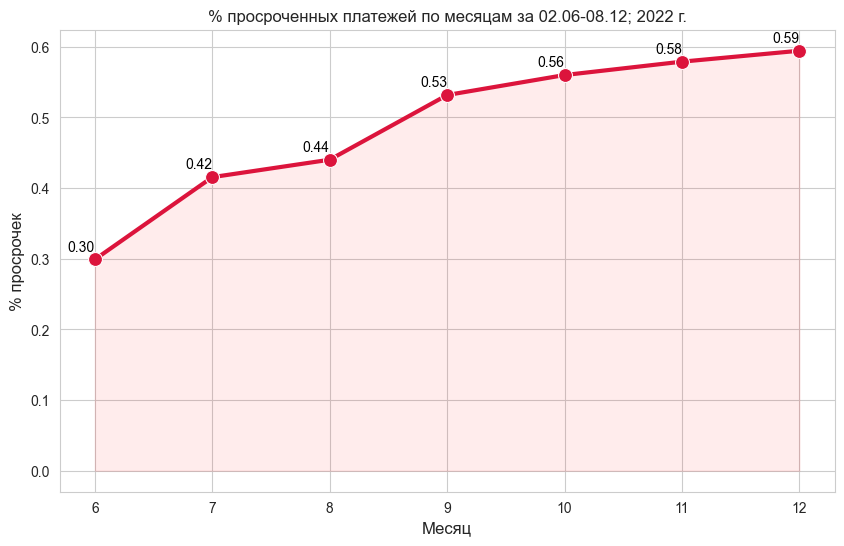

In [14]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

sns.lineplot(x='month', y='percent_overdued_payments', data=month_overdue, marker='o', linewidth=3, markersize=10, color='crimson')
plt.fill_between(month_overdue['month'], month_overdue['percent_overdued_payments'], color='red', alpha=0.075)

for x, y in zip(month_overdue['month'], month_overdue['percent_overdued_payments']):
    plt.text(x, y + max(month_overdue['percent_overdued_payments'])*0.02, f"{y:.2f}", ha='right', fontsize=10, color='black')
    
plt.title("% просроченных платежей по месяцам за 02.06-08.12; 2022 г.", fontsize=12)
plt.xlabel("Месяц", fontsize=12)
plt.ylabel("% просрочек", fontsize=12)
plt.show()

### Регрессионный анализ

**Строим регрессию и смотрим саммари**

In [15]:
X = [1,2,3,4,5,6]
y = month_overdue['percent_overdued_payments'][:6]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

C:\Users\maxii\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     percent_overdued_payments   R-squared:                       0.931
Model:                                   OLS   Adj. R-squared:                  0.913
Method:                        Least Squares   F-statistic:                     53.62
Date:                       Tue, 26 Aug 2025   Prob (F-statistic):            0.00185
Time:                               01:57:16   Log-Likelihood:                 13.465
No. Observations:                          6   AIC:                            -22.93
Df Residuals:                              4   BIC:                            -23.35
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2784      0.029      9.520      0.001       0.197       0.360
x1             0.0550      0.008      7.323      0.002       0.034       0.076
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.038
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.563
Skew:                          -0.089   Prob(JB):                        0.755
Kurtosis:                       1.511   Cond. No.                         9.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Выводы о регрессии

Модель: **percent_overdued_payments** = 0.2784 + 0.0550 х **period** + e

1. Prob (F-statistic):	0.00185 < 0.05 **=> В целом регрессия значима** (хотя наблюдений всё же мало)
2. Время значимо, pv = 0.002 < 0.05 **=> Есть динамика от времени**
3. b1 = 0.0550 **=> % Просроченных платежей растет в среднем на 5.5% каждый месяц.** Истиное значение: 3.4 < b1 < 7.6

**Прогноз:**

(Но модель на 6 наблюдениях не очень точная)

In [16]:
print(f'В декабре будет {model.predict([1, 7])[0]*100:.2f}% просроченных платежей')

В декабре будет 66.34% просроченных платежей


### Изображаем на графике регрессию

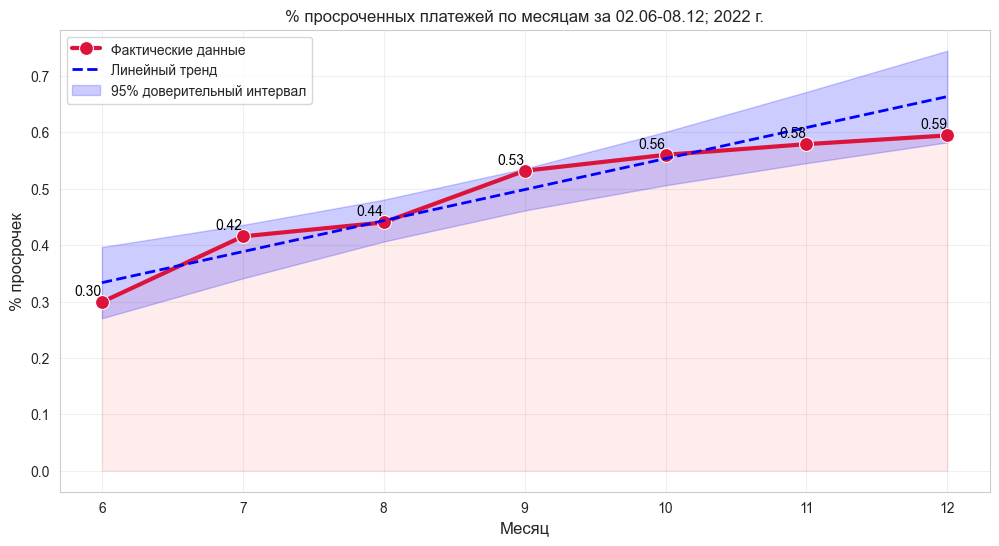

In [17]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))
sns.lineplot(x='month', y='percent_overdued_payments', data=month_overdue, marker='o', linewidth=3, markersize=10, color='crimson', label='Фактические данные')
plt.fill_between(month_overdue['month'], month_overdue['percent_overdued_payments'], color='red', alpha=0.075)

months_for_prediction = np.arange(1, 8) 
X_pred = sm.add_constant(months_for_prediction)
y_pred = model.predict(X_pred)

plt.plot(months_for_prediction+5, y_pred, 'b--', linewidth=2, label='Линейный тренд')
predictions = model.get_prediction(X_pred)
pred_summary = predictions.summary_frame(alpha=0.05)
plt.fill_between(months_for_prediction+5,
                 pred_summary['mean_ci_lower'], 
                 pred_summary['mean_ci_upper'],  
                 color='blue', alpha=0.2, label='95% доверительный интервал')

for x, y in zip(month_overdue['month'], month_overdue['percent_overdued_payments']):
    plt.text(x, y + max(month_overdue['percent_overdued_payments'])*0.02, f"{y:.2f}", ha='right', fontsize=10, color='black')

plt.title("% просроченных платежей по месяцам за 02.06-08.12; 2022 г.", fontsize=12)
plt.xlabel("Месяц", fontsize=12)
plt.ylabel("% просрочек", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

# Итоги

### 1. Мы видим, что доля просроченных платежей увеличивалась с Июня (в среднем на 5.5%).
### 2. Мы доказали, что есть тенденция. Фактор времени оказался статистически значимым в регрессии.
### 3. Также построили график с доверительным интервалом. В его пределах, скорее всего, окажется новый % просроченных платежей.
### 4. Хотя данных недостаточно, можно сказать, что в декабре пока продолжается тенденция роста % просроченных платежей.


